In [1]:

import ray
import json
import torch, argparse, os, time, sys, shutil, logging
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import torch.nn.functional as F
import torch.nn as nn

from torch.nn import MaxPool2d, ReLU, Linear, Upsample

from matplotlib import pyplot as plt
import matplotlib as mpl

import biotorch
from math import log

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import argparse

In [2]:
import glob
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

from skimage.transform import resize

### Read test data

In [3]:
numIterations = 100

#adding a parseable parameter for training algorithm. 
parser = argparse.ArgumentParser(description='PtychoNN.')
parser.add_argument('-train_alg',type=str, default="BP")

args, unparsed = parser.parse_known_args()

# learning algorithms supported in this experiment. 
if args.train_alg=="BP":
    from torch.nn import Conv2d

#epochs = 60
batch = 64
h,w = 64,64
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
n_valid = 805 #How much to reserve for validation

path = os.getcwd()


X_test = np.load('data/X_test.npy')
Y_I_test = np.load ('data/Y_I_test.npy')
Y_phi_test = np.load('data/Y_phi_test.npy')
ntest = X_test.shape[0]*X_test.shape[1]
nltest = int(Y_I_test.shape[0]**0.5)

#Test data
X_test_tensor = torch.Tensor(X_test)
Y_I_test_tensor = torch.Tensor(Y_I_test)
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

In [4]:
#load the data for braggNN
def load_data():

    data_diffr = np.load('data/20191008_39_diff.npz')['arr_0']
    real_space = np.load('data/20191008_39_amp_pha_10nm_full.npy')#, allow_pickle=True)
    amp = np.abs(real_space)
    ph = np.angle(real_space)
    amp.shape


    data_diffr = np.load('data/20191008_39_diff.npz')['arr_0']
    real_space = np.load('data/20191008_39_amp_pha_10nm_full.npy')#, allow_pickle=True)
    amp = np.abs(real_space)
    ph = np.angle(real_space)
    amp.shape

    #plt.matshow(np.log10(data_diffr[0,0]))

    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
    for i in range(data_diffr.shape[0]):
        for j in range(data_diffr.shape[1]):
            data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

    tst_strt = amp.shape[0]-nltest #Where to index from

    X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,np.newaxis,:,:]
    X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,np.newaxis,:,:]
    Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,np.newaxis,:,:]
    Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,np.newaxis,:,:]
    Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,np.newaxis,:,:]
    Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,np.newaxis,:,:]

    ntrain = X_train.shape[0]*X_train.shape[1]
    ntest = X_test.shape[0]*X_test.shape[1]

    X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

    #Training data
    X_train_tensor = torch.Tensor(X_train)
    Y_I_train_tensor = torch.Tensor(Y_I_train)
    Y_phi_train_tensor = torch.Tensor(Y_phi_train)

    #Test data
    X_test_tensor = torch.Tensor(X_test)
    Y_I_test_tensor = torch.Tensor(Y_I_test)
    Y_phi_test_tensor = torch.Tensor(Y_phi_test)

    train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
    test_data = TensorDataset(X_test_tensor,Y_I_test_tensor,Y_phi_test_tensor)

    n_train = X_train_tensor.shape[0]
    train_data2, valid_data = torch.utils.data.random_split(train_data,[n_train-n_valid,n_valid])

    #download and load training data
    trainloader = DataLoader(train_data2, batch_size=batch, shuffle=True, num_workers=4)
    validloader = DataLoader(valid_data, batch_size=batch, shuffle=True, num_workers=4)
    testloader = DataLoader(test_data, batch_size=batch, shuffle=False, num_workers=4)

    iterations_per_epoch = np.floor((n_train-n_valid)/batch)+1 #Final batch will be less than batch size
    step_size = 6*iterations_per_epoch
    return trainloader, validloader, testloader, step_size

### Load the model from the epoch with lowest validation error

In [5]:
def insertConv(layers, depth, in_channels, out_channels):
    layers.append(Conv2d(in_channels, out_channels, 3, stride=1, padding=(1,1)))
    layers.append(torch.nn.ReLU())
    for i in range(depth-1):
        layers.append(Conv2d(out_channels, out_channels, 3, stride=1, padding=(1,1)))
        layers.append(torch.nn.ReLU())
    
    return layers 

class PtychoNN(torch.nn.Module):  
    def __init__(self, encode_depth=2, decode_depth_1=2, decode_depth_2=2, en_filters=[], d1_filters=[], d2_filters=[]): 
        super().__init__()

        #define layers in a list:
        elayers = []
        elayers.append(Conv2d(in_channels=1, out_channels=en_filters[0], kernel_size=3, stride=1, padding=(1,1)))
        elayers.append(ReLU())
        elayers = insertConv(elayers, encode_depth-1, en_filters[0], en_filters[0])
        elayers.append(MaxPool2d((2,2)))
        elayers = insertConv(elayers, encode_depth, en_filters[0], en_filters[1])
        elayers.append(MaxPool2d((2,2)))
        elayers = insertConv(elayers, encode_depth, en_filters[1], en_filters[2])
        elayers.append(MaxPool2d((2,2)))

        self.encoder = torch.nn.Sequential(*elayers)
        
        
        d1layers = []
        d1layers = insertConv(d1layers,decode_depth_1, en_filters[2], d1_filters[0])
        d1layers.append(Upsample(scale_factor=2, mode='bilinear'))
        d1layers = insertConv(d1layers, decode_depth_1, d1_filters[0], d1_filters[1])
        d1layers.append(Upsample(scale_factor=2, mode='bilinear'))
        d1layers = insertConv(d1layers, decode_depth_1, d1_filters[1], d1_filters[2])
        d1layers.append(Upsample(scale_factor=2, mode='bilinear'))
        d1layers.append(Conv2d(d1_filters[2], 1, 3, stride=1, padding=(1,1)))
        d1layers.append(torch.nn.Sigmoid())

        self.decoder1 = torch.nn.Sequential(*d1layers)
       

        
        d2layers = []
        d2layers = insertConv(d2layers, decode_depth_2, en_filters[2], d2_filters[0])
        d2layers.append(Upsample(scale_factor=2, mode='bilinear'))
        d2layers = insertConv(d2layers, decode_depth_2, d2_filters[0], d2_filters[1])
        d2layers.append(Upsample(scale_factor=2, mode='bilinear'))
        d2layers = insertConv(d2layers, decode_depth_2, d2_filters[1], d2_filters[2])
        d2layers.append(Upsample(scale_factor=2, mode='bilinear'))
        d2layers.append(Conv2d(d2_filters[2], 1, 3, stride=1, padding=(1,1)))
        d2layers.append(torch.nn.Tanh())

        self.decoder2 = torch.nn.Sequential(*d2layers)


    def forward(self,x):
        x1 = self.encoder(x)
        amp = self.decoder1(x1)
        ph = self.decoder2(x1)

        #Restore -pi to pi range
        ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
loss_func = torch.nn.L1Loss()
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf, 'best_amp_loss': np.inf, 'best_phase_loss': np.inf}

en_filters = [209, 120, 117]
d1_filters = [138, 65, 117]
d2_filters = [115, 233, 123]

edepth = 2
d1depth = 1
d2depth = 3
lrate = 0.000968958
epochs = 86

embed_dim = 64
model = PtychoNN(encode_depth=edepth, decode_depth_1=d1depth, decode_depth_2=d2depth, en_filters=en_filters, d1_filters=d1_filters, d2_filters=d2_filters)
model.load_state_dict(torch.load('./final.pth', map_location=torch.device('cpu')))

# load data from the DataLoader 
# call the data loader functions directly here.
dl_train, dl_valid, dl_test, step_size = load_data()

cpu


### Make prediction using the diffraction data alone

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])


<Figure size 432x288 with 0 Axes>

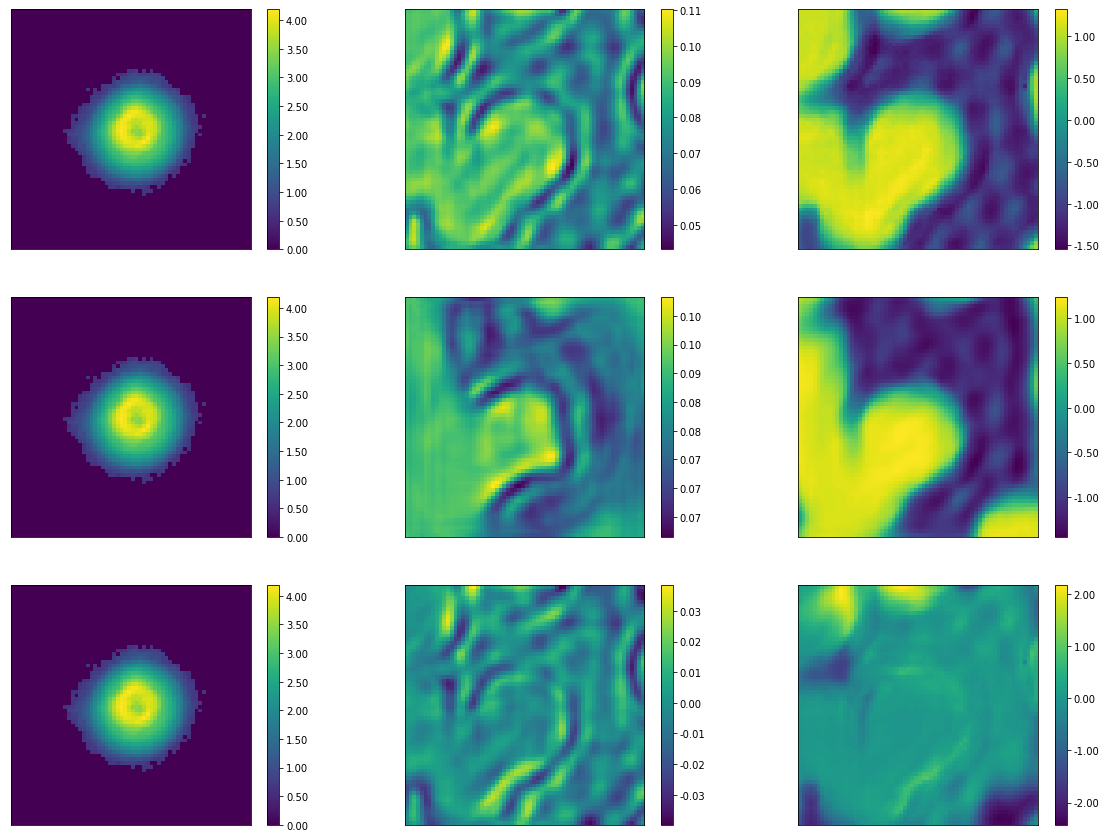

In [6]:
for k, (ft_images,amps,phs) in enumerate(dl_test):
    print(ft_images.shape)       
    ft_images = ft_images.to(device)
    print(amps.shape)
    amps = amps.to(device)
    phs = phs.to(device)
    pred_amps, pred_phs = model(ft_images) #Forward pass
    pred_amps = pred_amps.detach()
    pred_phs = pred_phs.detach()



    h,w = 64,64
    plt.viridis()
    n = 1
    f,ax=plt.subplots(3,3,figsize=(20, 15))
    #plt.gcf().text(0.09, 0.6, "Input", fontsize=12)
    #plt.gcf().text(0.09, 0.8, "Input", fontsize=12)
    #plt.gcf().text(0.09, 1.2, "Input", fontsize=12)
    #plt.gcf().text(0.22, 0.5, "Difference I", fontsize=12)
    #plt.gcf().text(0.22, 0.4, "True Phi", fontsize=12)
   # plt.gcf().text(0.32, 0.27, "Predicted Phi", fontsize=12)
    #plt.gcf().text(0.32, 0.17, "Difference Phi", fontsize=12)
    
    j=0
    i=0
    # display FT
    im=ax[0,0].imshow(np.log10(ft_images[0,:,:,:].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,0], format='%.2f')
    ax[0,0].get_xaxis().set_visible(False)
    ax[0,0].get_yaxis().set_visible(False)

    # display FT
    im=ax[1,0].imshow(np.log10(ft_images[0,:,:,:].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[1,0], format='%.2f')
    ax[1,0].get_xaxis().set_visible(False)
    ax[1,0].get_yaxis().set_visible(False)

    # display FT
    im=ax[2,0].imshow(np.log10(ft_images[0,:,:,:].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[2,0], format='%.2f')
    ax[2,0].get_xaxis().set_visible(False)
    ax[2,0].get_yaxis().set_visible(False)

    # display original intens
    im=ax[0,1].imshow(amps[0,:,:,:].reshape(h, w))
    plt.colorbar(im, ax=ax[0,1], format='%.2f')
    ax[0,1].get_xaxis().set_visible(False)
    ax[0,1].get_yaxis().set_visible(False)

    # display original phase
    im=ax[0,2].imshow(phs[0,:,:,:].reshape(h, w))
    plt.colorbar(im, ax=ax[0,2], format='%.2f')
    ax[0,2].get_xaxis().set_visible(False)
    ax[0,2].get_yaxis().set_visible(False)
        
    # display predicted intens
    im=ax[1,1].imshow(pred_amps[0,:,:,:].reshape(h, w))
    plt.colorbar(im, ax=ax[1,1], format='%.2f')
    ax[1,1].get_xaxis().set_visible(False)
    ax[1,1].get_yaxis().set_visible(False)
        
    # display predicted phase
    im=ax[1,2].imshow(pred_phs[0,:,:,:].reshape(h, w))
    plt.colorbar(im, ax=ax[1,2], format='%.2f')
    ax[1,2].get_xaxis().set_visible(False)
    ax[1,2].get_yaxis().set_visible(False)
        
    #Difference in amplitude
    im=ax[2,1].imshow(amps[0,:,:,:].reshape(h, w)-pred_amps[0,:,:,:].reshape(h, w))
    plt.colorbar(im, ax=ax[2,1], format='%.2f')
    ax[2,1].get_xaxis().set_visible(False)
    ax[2,1].get_yaxis().set_visible(False)
        
    # Difference in phase
    im=ax[2,2].imshow(phs[0,:,:,:].reshape(h, w)-pred_phs[0,:,:,:].reshape(h, w))
    plt.colorbar(im, ax=ax[2,2], format='%.2f')
    ax[2,2].get_xaxis().set_visible(False)
    ax[2,2].get_yaxis().set_visible(False)
    plt.savefig('output.jpg', dpi=200)
    plt.show()


    break


# Plot some instances of the test data, it's FT and the CNN prediction

In [7]:
h,w = 64,64
ntest=preds_intens[0].shape[0]
plt.viridis()
f,ax=plt.subplots(7,1,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

j=0

# display FT
im=ax[0,0].imshow(np.log10(X_test[j].reshape(h, w)+1))
plt.colorbar(im, ax=ax[0,i], format='%.2f')
ax[0,0].get_xaxis().set_visible(False)
ax[0,0].get_yaxis().set_visible(False)

# display original intens
im=ax[1,0].imshow(Y_I_test[j].reshape(h, w))
plt.colorbar(im, ax=ax[1,i], format='%.2f')
ax[1,0].get_xaxis().set_visible(False)
ax[1,0].get_yaxis().set_visible(False)
    
# display predicted intens
im=ax[2,0].imshow(preds_intens[0][j].reshape(h, w))
plt.colorbar(im, ax=ax[2,i], format='%.2f')
ax[2,0].get_xaxis().set_visible(False)
ax[2,0].get_yaxis().set_visible(False)
    
# display original phase
im=ax[4,0].imshow(Y_phi_test[j].reshape(h, w))
plt.colorbar(im, ax=ax[4,i], format='%.2f')
ax[4,0].get_xaxis().set_visible(False)
ax[4,0].get_yaxis().set_visible(False)
    
# display predicted phase
im=ax[5,0].imshow(preds_intens[1][j].reshape(h, w))
plt.colorbar(im, ax=ax[5,i], format='%.2f')
ax[5,0].get_xaxis().set_visible(False)
ax[5,0].get_yaxis().set_visible(False)
    
#Difference in amplitude
im=ax[3,0].imshow(Y_I_test[j].reshape(h, w)-preds_intens[0][j].reshape(h, w))
plt.colorbar(im, ax=ax[3,i], format='%.2f')
ax[3,0].get_xaxis().set_visible(False)
ax[3,0].get_yaxis().set_visible(False)
    
# Difference in phase
im=ax[6,0].imshow(Y_phi_test[j].reshape(h, w)-preds_intens[1][j].reshape(h, w))
plt.colorbar(im, ax=ax[6,i], format='%.2f')
ax[6,0].get_xaxis().set_visible(False)
ax[6,0].get_yaxis().set_visible(False)
    
plt.show()

NameError: name 'preds_intens' is not defined

## Plot NN predictions from adjacent scan points to see variation 

In [ ]:
tst_side = 60
fig, ax = plt.subplots(4,4, figsize=(12,6))
ax[0,0].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[9,9]))
ax[0,1].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[9,10]))
ax[0,2].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[9,11]))
ax[1,0].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[10,9]))
ax[1,1].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[10,10]))
ax[1,2].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[10,11]))
ax[2,0].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[11,9]))
ax[2,1].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[11,10]))
ax[2,2].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[11,11]))

# Stitch predictions together

In [ ]:
point_size = 3
overlap = 4*point_size

In [ ]:

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = preds_intens[0].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1


In [ ]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = preds_intens[1].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1


In [ ]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

## Plot the ePIE reconstruction, the PtychoNN prediction and the difference between the two

In [ ]:
amp = Y_I_test.reshape(nltest,nltest,64,64)
ph = Y_phi_test.reshape(nltest,nltest,64,64)

In [ ]:
#minc = min(stitched_amp_down.min(),amp[:,:,32,32].min()) #Set common color range respecting bounds of both
#maxc = max(stitched_amp_down.max(),amp[:,:,32,32].max()) 

plt.rcParams.update({'font.size': 26})
fig, ax = plt.subplots(1,3,figsize=(20,12))

im=ax[0].imshow(amp[:,:,32,32])#,vmin=minc, vmax=maxc)
ax[0].axis('off')
plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)

im=ax[1].imshow(stitched_amp_down)#,vmin=minc, vmax=maxc)
plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
ax[1].axis('off')

im=ax[2].imshow(stitched_amp_down-amp[:,:,32,32])
plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].axis('off')

In [ ]:

fig, ax = plt.subplots(1,3,figsize=(20,10))

im=ax[0].imshow(ph[:,:,32,32])#,vmin=minc, vmax=maxc)
plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
ax[0].axis('off')

im=ax[1].imshow(stitched_phase_down)#,vmin=minc, vmax=maxc)
plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
ax[1].axis('off')

im=ax[2].imshow(stitched_phase_down-ph[:,:,32,32],vmin=-1.35, vmax=1.2)
plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].axis('off')

In [ ]:
(stitched_phase_down-ph[:,:,32,32]).max()

### Quantify MSE error between phase retrieval and PtychoNN

In [ ]:
from sklearn.metrics import mean_squared_error as mse
print ("MSE in amplitude: ", mse(stitched_amp_down, amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, ph[:,:,32,32]))